In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from itertools import chain
from sys import platform
from copy import deepcopy as dc

vims_wave = np.loadtxt('vims_wave.txt')

new_array = ['_0405','_0607','_0809','_1011','_1213','_1415','_1617']
if platform == 'darwin' or platform == 'win32' or platform == 'linux':
    for number in new_array:
        new_string = 'df'+number+' = pd.read_pickle("e_data/data'+number+'.pkl")'
        exec(new_string)
else:
    df_list = []
    for number in new_array:
        new_string = 'df'+number+' = pd.read_csv("e_data/data'+number+'.csv")'
        exec(new_string)
        df = 'df'+number
        new_df = locals()[df]
        df_list.append(new_df)
    for df in df_list:
        for i in range(len(df['spectrum'])):
            df['spectrum'][i] = np.array([float(x) for x in df['spectrum'][i][1:-1].split(',')])

In [2]:
spec_list = []
for number in new_array:
    my_string = 'spec'+number+' = df'+number+"['spectrum']"
    exec(my_string)
    spec = 'spec'+number
    spec_list.append(locals()[spec])

time_list_i = []
for number in new_array:
    my_string = 'ettime'+number+' = df'+number+"['ettime']"
    exec(my_string)
    time = 'ettime'+number
    time_list_i.append(locals()[time])

time_list_f = []
for df in time_list_i:
    for time in df:
        time_list_f.append(time)

total_spectrum = []
for spec in spec_list:
    for spectrum in spec:
        total_spectrum.append(spectrum)

total_spectrum = np.asarray(total_spectrum)
total_spectrum_2 = dc(total_spectrum)
print('List 1: '+str(np.shape(total_spectrum)))
print('List 2 (Copy): '+str(np.shape(total_spectrum_2))) # Confirms that DeepCopy works correctly

List 1: (12655, 256)
List 2 (Copy): (12655, 256)


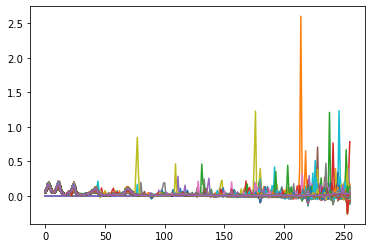

In [4]:
%matplotlib inline
plt.figure(facecolor='white')
for i in range(len(total_spectrum)):
    plt.plot(total_spectrum[i])
plt.show()

In [5]:
#First we'd like to delete sectra of zero values
orig = total_spectrum.copy()
ind  = np.where(orig[:,0]<.01)
orig = np.delete(orig,ind,axis=0)

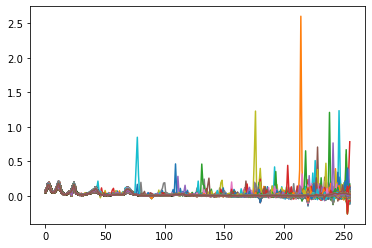

In [6]:
%matplotlib inline
plt.figure(facecolor='white')
for i in range(len(orig)):
    plt.plot(orig[i])
plt.show()

In [7]:
#Next we replace all values less than zero with NaN
ind = np.where(orig<0)
orig[ind] = 0

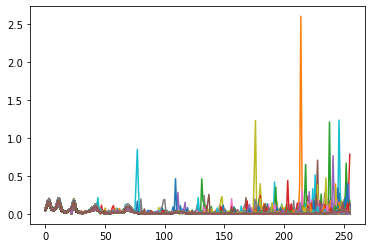

In [8]:
%matplotlib inline
plt.figure(facecolor='white')
for i in range(len(orig)):
    plt.plot(orig[i])
plt.show()

In [9]:
from scipy.stats import norm

#Now we have options the first can be an in place median filter
medi = orig.copy()
for i in range(256):
    vals = medi[:,i]
    mu,sigma = norm.fit(vals)
    inds = np.where(np.abs(vals-mu)/sigma>3)[0]
    for ind in inds:
        if i<2:
            median = np.median(medi[ind,:i+4])
        elif i>253:
            median = np.median(medi[ind,i-4:])
        else:
            median = np.median(medi[ind,i-2:i+2])
        medi[ind,i] = median

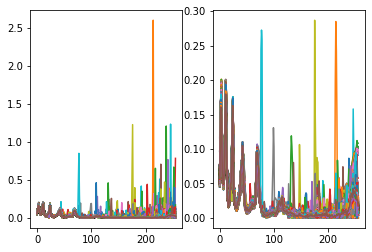

In [14]:
%matplotlib inline
fig,[ax1,ax2] = plt.subplots(1,2)
fig.set_facecolor('white')

for i in range(len(orig)):
    ax1.plot(orig[i])

for i in range(len(medi)):
    ax2.plot(medi[i])
    
plt.show()

In [11]:
from scipy.stats import norm

#Now we have options the first can be an in place median filter
perc = orig.copy()
for i in range(256):
    vals = perc[:,i]
    p05 = np.percentile(vals,5)
    perc[np.where(vals<p05),i] = p05
    p95 = np.percentile(vals,95)
    perc[np.where(vals>p95),i] = p95

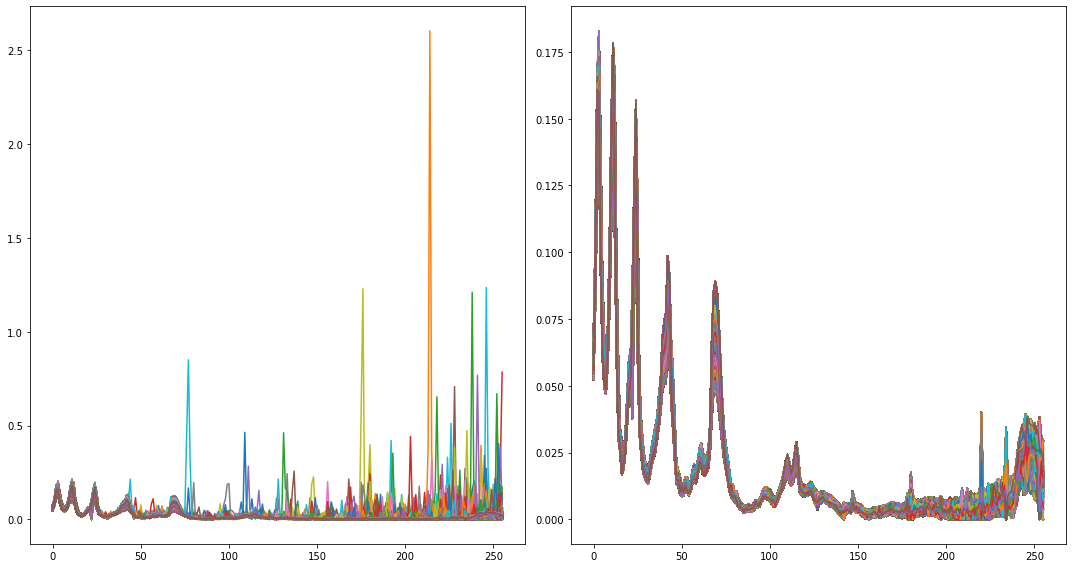

In [16]:
%matplotlib inline
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(15,8))
fig.set_facecolor('white')
for i in range(len(orig)):
    ax1.plot(orig[i])

for i in range(len(medi)):
    ax2.plot(perc[i])

fig.tight_layout()
plt.show()

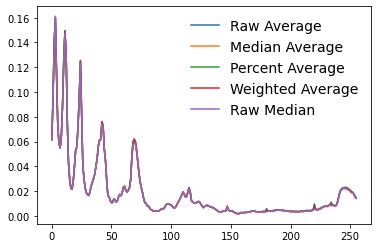

In [15]:
%matplotlib inline

raw_avg = np.average(orig,axis=0)
med_avg = np.average(medi,axis=0)
per_avg = np.average(perc,axis=0)
wei_avg = []
for i in range(256):
    mu,sigma = np.average(perc[:,i]),np.std(perc[:,i])
    weights = sigma/np.abs(perc[:,i]-mu)
    wei_avg.append(np.sum(weights*perc[:,i])/np.sum(weights))
wei_avg = np.asarray(wei_avg)


fig,ax = plt.subplots()
fig.set_facecolor('white')
ax.plot(raw_avg,label='Raw Average')
ax.plot(med_avg,label='Median Average')
ax.plot(per_avg,label='Percent Average')
ax.plot(wei_avg,label='Weighted Average')
ax.plot(np.median(orig,axis=0),label='Raw Median')
plt.legend(frameon=False,prop={'size':14})

plt.show()